In [4]:
#Imports
#%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    #DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

import datetime
import pandas as pd
import numpy as np

from category_encoders import OrdinalEncoder, OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#Yes today (Regression)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
#Not today (Classification)
#Tomorrow, both
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
#import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt

In [5]:
#Raw meterorological data
met_readings = pd.read_csv('BW_MET46251.txt', sep=' ', skipinitialspace=True)

#Basically government-made features made out of spectral data
directions = pd.read_csv('BW_SPEC46251.spec.txt', sep=' ', skipinitialspace=True)


def timeFixer(df):
    #first row is weird
    row1 = df.index[0]
    #drop weird first row
    df.drop(df.index[0],inplace=True)
    #add 00 for seconds
    df['ss'] = '00'
    #create date column
    df['Date'] = df['#YY']+'/'+df['MM']+'/'+df['DD']+' '+df['hh']+':'+df['mm']+':'+df['ss']
    #Convert df['Date'] to DateTime object
    #df['Date'] = datetime.datetime.strptime(df['Date'], '%Y/%m/%d %H:%M:%s.%f')
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
    #Index on date
    df.index = df['Date']
    #Drop now uneeded date & time columns
    df.drop(columns=['#YY','MM','DD','hh','mm','ss','Date'],inplace=True)
    #If more than 11 columns, drop extras
    extras = ['WDIR','WSPD','GST','PRES','ATMP','DEWP','VIS','PTDY','TIDE','MWD','WVHT','APD']
    if len(df.columns) > 11:
        df.drop(columns=extras, inplace=True)
    
    return df

met = timeFixer(met_readings)
directions = timeFixer(directions)

new_test1 = pd.read_csv('Test46251.txt', sep=' ', skipinitialspace=True)
new_test2 = pd.read_csv('test2.spec.txt', sep=' ', skipinitialspace=True)
nt1 = timeFixer(new_test1)
nt2 = timeFixer(new_test2)

display(met.head(1))
display(directions.head(1))

combined = pd.concat([met,directions],axis=1)
new_test = pd.concat([nt1,nt2],axis=1)

display(combined.head(2))
print('Combined shape:',combined.shape)
combined = combined.dropna()
new_test = new_test.dropna()
print('Combined shape minus rows with NaNs',combined.shape)

#Convert numericals to floats
numerical_cols = ['WVHT','DPD','WTMP','SwH','SwP','WWH','WWP','APD','MWD']
categorical_cols = ['SwD','WWD','STEEPNESS']
combined[numerical_cols] = combined[numerical_cols].astype('float')
new_test[numerical_cols] = new_test[numerical_cols].astype('float')

# #OHE steepness column (can just ohe)
# keywords = ['AVERAGE','SWELL','STEEP','VERY_STEEP']
# for col in keywords:
#     combined[col] = (combined['STEEPNESS']
#                     .fillna('')
#                     .str.lower()
#                     .str.contains(col, regex=True)
#                     .astype(int))

combined_comp = combined['STEEPNESS'].value_counts(normalize=True)
most_class = combined['STEEPNESS'].value_counts(normalize=True).max()
print('---')
print('Relative Frequency:',combined_comp)
print('---')
print('Proportion of most common class:',(most_class*100))
#The most common class is 'average' at 58%

#There are 45 days so 27/9/9 split
cutoff_train = '2021-04-01 00:00:00'
cutoff_val = '2021-04-10 00:00:00'
cutoff_test = '2021-04-20 00:00:00'
cutoff_new_test = '2021-4-20 00:00:00'

train = combined.loc[combined.index < cutoff_train]
combined = combined.loc[combined.index > cutoff_train]

val = combined.loc[combined.index < cutoff_val]
combined = combined.loc[combined.index > cutoff_val]

test = combined.loc[combined.index < cutoff_test]

test_new = new_test.loc[new_test.index>cutoff_test]

train_range = [train.index[1],train.index[-1]]
val_range = [val.index[1],val.index[-1]]
test_range = [test.index[1],test.index[-1]]
print('---')
print('Train:',train_range,'Length:',len(train))
print('Val:',val_range,'Length:',len(val))
print('Test:',test_range,'Length:',len(test))
print(len(test_new))

target = 'MWD'
X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

X_new_test = new_test.drop(columns=target)
y_new_test = new_test[target]

print('---')
print('Train:',X_train.shape,y_train.shape,'Val:',X_val.shape,y_val.shape,'Test:',X_test.shape,y_test.shape)

print('---')
baseline_acc = y_train.mean()
y_pred = [y_train.mean()] * len(y_train)
print('Mean Wave Direction:',round(baseline_acc,2))
print('Mean Absolute Error of Naive Regressor:',mean_absolute_error(y_train,y_pred))



,DPD,WTMP
Date,,
2021-04-19 20:26:00,14,16.1


,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
Date,,,,,,,,,,
2021-04-19 20:26:00,1.3,0.7,14.3,1.1,6.7,SSW,W,AVERAGE,5.6,198


,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
Date,,,,,,,,,,,,
2021-03-05 00:26:00,10,14.9,1.1,0.6,12.5,0.9,9.9,W,W,AVERAGE,7.7,276
2021-03-05 00:56:00,11,14.4,1.1,0.6,10.5,0.9,9.9,W,W,AVERAGE,7.5,264


Combined shape: (1786, 12)
Combined shape minus rows with NaNs (1744, 12)
---
Relative Frequency: AVERAGE       0.583142
VERY_STEEP    0.198968
SWELL         0.112385
STEEP         0.105505
Name: STEEPNESS, dtype: float64
---
Proportion of most common class: 58.31422018348624
---
Train: [Timestamp('2021-03-05 00:56:00'), Timestamp('2021-03-31 23:56:00')] Length: 856
Val: [Timestamp('2021-04-01 00:56:00'), Timestamp('2021-04-09 23:56:00')] Length: 419
Test: [Timestamp('2021-04-10 00:56:00'), Timestamp('2021-04-19 20:26:00')] Length: 469
158
---
Train: (856, 11) (856,) Val: (419, 11) (419,) Test: (469, 11) (469,)
---
Mean Wave Direction: 255.24
Mean Absolute Error of Naive Regressor: 26.141649925757708


In [7]:
#Adaptive Boosting Regressor
model_abr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    AdaBoostRegressor(random_state=42)
)
model_abr.fit(X_train,y_train)

/Users/rowenwitt/.local/share/virtualenvs/testenv-_GQo1gTb/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['SwD', 'WWD', 'STEEPNESS'],
                               use_cat_names=True)),
                ('adaboostregressor', AdaBoostRegressor(random_state=42))])

In [8]:
def check_metrics(model):
    print('---')
    print(model)
    print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
    print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
    print('Validation R^2:', model.score(X_val,y_val))
    print()
    print()

    
models = [model_abr]

for m in models:
    check_metrics(m)

---
Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['SwD', 'WWD', 'STEEPNESS'],
                               use_cat_names=True)),
                ('adaboostregressor', AdaBoostRegressor(random_state=42))])
Training MAE: 4.937723735251001
Validation MAE: 5.8945584794076025
Validation R^2: 0.9549167976634525




In [9]:
#Real Prediction
y_pred = model_abr.predict(X_new_test)
test_mae = mean_absolute_error(y_new_test,model_abr.predict(X_new_test))
test_R2 = model_abr.score(X_new_test,y_new_test)

print(test_mae,test_R2)

5.288878571039399 0.9614769957410216


In [ ]:
##Below is tidal stuff

In [267]:
#Working with tides
tides_dates_times = pd.read_csv('BW_MET46251.txt', sep=' ', skipinitialspace=True)
tides = pd.read_csv('9413745.txt',delim_whitespace=True)

tides_dates_times['Date'] = tides_dates_times['#YY']+'/'+tides_dates_times['MM']+'/'+tides_dates_times['DD']+' '+tides_dates_times['hh']+':'+tides_dates_times['mm']

#Now I need to convert both time formats into common datetime format expected by prophet, which I'm 
#Hoping to use to infill tidal values, though there is likely a fundamentally more sound way
#To accomplish this.  Tides need to convert to from 24 hour time to datetime.
#from datetime import datetime

tides['Time'] = tides['Day']+' '+tides['Time']
for i in tides.Time:
    tides['a'] = tides['Time'].str[:2].astype('int')
    tides['b'] = tides['Time'].str[3:5].astype('int')
    tides['c'] = tides['Time'].str[-2:]
    tides['d'] = tides['Time']
drop = ['Day','Time']
tides.drop(columns=drop,inplace=True)

a = tides.loc[tides['c']=='PM']
d = a.copy()
d['a'] = d['a']+12
b = tides.loc[tides['c']=='AM']
c = pd.concat([b,d])
#c['dt'] = c.index+' '+c['a'].astype('str').str[0:4]+':'+c['b'].astype('str')+':'+'00'
c['e'] = c.index+' '+c['d']
c['dt'] = pd.to_datetime(c['e'],infer_datetime_format=True)
c.index = c['dt']
drop=['a','b','c','d','dt','e']
c.drop(columns=drop,inplace=True)
c = c.sort_index()
c['time'] = c.index

c['time2'] = c['time'].shift(1)
c['time3'] = (c['time']-c['time2']).astype('timedelta64[h]')
c['Pred2'] = c['Pred'].shift(1)
c['per_dif'] = c['Pred']-c['Pred2']
c['del'] = c['per_dif'] / c['time3']

In [332]:
#To impute tidal data
t = []    
pp = []
p = []
for j in range(1,len(c)):    #For length of tide dataframe
    p = []
    for i in range(1,((c['time3'][j]).astype('int')-1)): #For the number of hours between observations j & j+1
        interval = datetime.timedelta(hours=i) #Add iterating hours
        t.append(c['time2'][j]+interval) #add to list of 6 datetimes
        p.append(abs(c['Pred'][j]+(c['del'][j]-(i)))) #Add prediction (prev pred + i * rate)
    p.reverse()
    pp.extend(p)
data = {'time':t,'Pred':pp}
mp = pd.DataFrame(data)
mp.index = mp['time']
mp.head(10)
cmp = pd.concat([mp,c])

In [289]:
import math

In [333]:

cmp.sort_index().head(50)

,time,Pred,Date,High/Low,time2,time3,Pred2,per_dif,del
2021-03-01 05:27:00,2021-03-01 05:27:00,1.030000,Mon,L,NaT,NaN,NaN,NaN,NaN
2021-03-01 06:27:00,2021-03-01 06:27:00,1.451667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 07:27:00,2021-03-01 07:27:00,2.451667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 08:27:00,2021-03-01 08:27:00,3.451667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 09:27:00,2021-03-01 09:27:00,4.451667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 11:27:00,2021-03-01 11:27:00,4.820000,Mon,H,2021-03-01 05:27:00,6.0,1.03,3.79,0.631667
2021-03-01 12:27:00,2021-03-01 12:27:00,4.686667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 13:27:00,2021-03-01 13:27:00,3.686667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 14:27:00,2021-03-01 14:27:00,2.686667,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2021-03-01 15:27:00,2021-03-01 15:27:00,1.686667,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [237]:
len(combined)

469

In [104]:
test = c['time2'][1:3]
t = test[1]
#f = t#
days = datetime.timedelta(hours=1)
print(t+days)
print(t)

2021-03-01 12:27:00
2021-03-01 11:27:00


In [166]:
c.head(10)

,Date,Pred,High/Low,time,time2,time3,Pred2,per_dif,del
dt,,,,,,,,,
2021-03-01 05:27:00,Mon,1.03,L,2021-03-01 05:27:00,NaT,NaN,NaN,NaN,NaN
2021-03-01 11:27:00,Mon,4.82,H,2021-03-01 11:27:00,2021-03-01 05:27:00,6.0,1.03,3.79,0.631667
2021-03-01 17:48:00,Mon,0.10,L,2021-03-01 17:48:00,2021-03-01 11:27:00,6.0,4.82,-4.72,-0.786667
2021-03-02 00:17:00,Tue,4.82,H,2021-03-02 00:17:00,2021-03-01 17:48:00,6.0,0.10,4.72,0.786667
2021-03-02 06:24:00,Tue,0.77,L,2021-03-02 06:24:00,2021-03-02 00:17:00,6.0,4.82,-4.05,-0.675000
2021-03-02 12:25:00,Tue,4.26,H,2021-03-02 12:25:00,2021-03-02 06:24:00,6.0,0.77,3.49,0.581667
2021-03-02 18:24:00,Tue,0.71,L,2021-03-02 18:24:00,2021-03-02 12:25:00,5.0,4.26,-3.55,-0.710000
2021-03-03 00:55:00,Wed,5.02,H,2021-03-03 00:55:00,2021-03-02 18:24:00,6.0,0.71,4.31,0.718333
2021-03-03 07:28:00,Wed,0.56,L,2021-03-03 07:28:00,2021-03-03 00:55:00,6.0,5.02,-4.46,-0.743333


In [ ]:
#s = SimpleImputer(strategy='median')
# s.fit(att_light)
# att_trans = s.transform(att_light)

# simple_tide = pd.DataFrame(att_trans)
# simple_tide.head(10)

# # att = pd.concat([c,X_train],axis=0)
# # att = att.sort_index()
# # att_lite = att['Pred']

# # # for i in range(att.shape[1]):
# # #     n_miss = att[[i]].isnull().sum()
# # #     perc = n_miss / dataframe.shape[0] * 100
# # #     print(('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc)))
# # att_lite = pd.DataFrame(att_lite)
# # att_light = att_lite.fillna(np.nan)

# # att_light
# # counter = 0
# # for i in range(0,len(cmp['Pred'])): 
# #     counter += 1
# #     if math.isnan(i)==False:
# #         lastPred = i
# #         lastDel = cmp['del'][i-1]
# #         print(lastDel)
# #     else:
# #         print(lastDel)
# #         cmp['Pred'][counter] = lastPred + (lastDel * counter)
# #cmp['Pred'][0] = 1
# #pred_na = cmp[cmp['Pred'].isna()==True]

In [12]:
#Step one: fit model to c
#Step two: get time intervals as datetime from combined
#Step three: predict tide over that range
#Step four: check answers somehow

In [58]:
c_low = c.loc[c['High/Low']=='L']
c_high = c.loc[c['High/Low']=='H']
clow = c_low.copy()
chigh = c_high.copy()
assert((len(c_low)+len(c_high))==len(c))

clow.head(5)
for i in clow['Pred']:
    a = i
    #new = datetime.timedelta(clow.index[i],clow.index[-1])
    #clow.loc[]
    print(a)

1.03
0.1
0.77
0.71
0.56
1.37
0.36
2.0
0.11
2.51
-0.2
2.81
-0.51
2.79
-0.74
2.55
-0.84
2.22
-0.8
1.88
-0.64
1.58
-0.37
1.32
-0.01
1.13
0.42
0.98
0.89
0.89
1.38
0.85
1.85
0.85
2.28
0.83
2.65
0.72
0.49
3.06
0.19
2.93
-0.12
2.62
-0.38
2.2
-0.54
1.71
-0.55
1.17
-0.41
0.64
-0.09
0.16
0.37
-0.22
0.93
-0.45
1.52


In [2]:
from prophet import Prophet
df_y = pd.DataFrame(c['Pred'])
df_y.insert(0,'ds',df_y.index)
df_z = df_y.reset_index()
#df_z['DS'] = df_z['dt']
df_z['y'] = df_z['Pred']
df_z.drop(columns=['dt','Pred'],inplace=True)
display(df_z)
future = pd.DataFrame(train.index)
future['ds'] = future['Date']
future.drop(columns=['Date'],inplace=True)
future
forecast = m.predict(future)
forecast = forecast[['yhat','yhat_lower','yhat_upper']].tail()
# []

Importing plotly failed. Interactive plots will not work.


NameError: name 'pd' is not defined

In [1]:
m = Prophet(changepoint_prior_scale=0.01,yearly_seasonality=True).fit(df_z)
fcst = m.predict(future)
fig = m.plot(fcst)
fig1 = m.plot(forecast)

NameError: name 'Prophet' is not defined

In [166]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-05 00:26:00,2.440188,2.295070,6.421110,2.440188,2.440188,1.849714,1.849714,1.849714,1.681851,1.681851,1.681851,0.167863,0.167863,0.167863,0.0,0.0,0.0,4.289902
1,2021-03-05 00:56:00,2.440331,2.149834,6.367994,2.440331,2.440331,1.687545,1.687545,1.687545,1.521057,1.521057,1.521057,0.166488,0.166488,0.166488,0.0,0.0,0.0,4.127875
2,2021-03-05 01:26:00,2.440473,1.955224,5.912253,2.440473,2.440473,1.463255,1.463255,1.463255,1.298192,1.298192,1.298192,0.165063,0.165063,0.165063,0.0,0.0,0.0,3.903729
3,2021-03-05 01:56:00,2.440616,1.583770,5.622532,2.440616,2.440616,1.198143,1.198143,1.198143,1.034552,1.034552,1.034552,0.163590,0.163590,0.163590,0.0,0.0,0.0,3.638759
4,2021-03-05 02:26:00,2.440759,1.318937,5.547357,2.440759,2.440759,0.916641,0.916641,0.916641,0.754572,0.754572,0.754572,0.162069,0.162069,0.162069,0.0,0.0,0.0,3.357400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2021-03-31 20:56:00,2.624289,1.511473,5.439712,2.624289,2.624289,0.863143,0.863143,0.863143,0.723121,0.723121,0.723121,0.140023,0.140023,0.140023,0.0,0.0,0.0,3.487432
852,2021-03-31 21:26:00,2.624431,1.634183,5.941818,2.624431,2.624431,1.175668,1.175668,1.175668,1.033136,1.033136,1.033136,0.142532,0.142532,0.142532,0.0,0.0,0.0,3.800100
853,2021-03-31 21:56:00,2.624574,1.843081,6.170712,2.624574,2.624574,1.448925,1.448925,1.448925,1.303944,1.303944,1.303944,0.144981,0.144981,0.144981,0.0,0.0,0.0,4.073499
854,2021-03-31 22:26:00,2.624717,2.101177,6.230141,2.624717,2.624717,1.671918,1.671918,1.671918,1.524551,1.524551,1.524551,0.147366,0.147366,0.147366,0.0,0.0,0.0,4.296635


In [738]:
# tide_dates = c.index
# comb_dates = combined.index
# print(tide_dates.shape,comb_dates.shape)
# tides_dates = pd.Series(list(tide_dates.astype('str')))
# combs_dates = pd.Series(list(comb_dates.astype('str')))
# all_dates = pd.concat([tides_dates,combs_dates])
# all_tides = pd.DataFrame(all_dates)
# all_tides.index=all_tides[0]
# all_tides['Pred'] = 0
# allall = all_tides.append(c)
# allall = allall.drop(columns=0)
# allall = allall.drop(columns='Date')
# allall.index = pd.to_datetime(allall.index,infer_datetime_format=True)

# all_all = allall.sort_index()
# all_all = all_all.iloc[0:234]
# tides_impute = all_all.copy()
# tides_impute = tides_impute.index.drop_duplicates()
# tides_impute
# all_all
# tides_impute

#from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# imp_mean = IterativeImputer(random_state=42)
# imp_mean.fit(att_light)
# exp_trans = imp_mean.transform(att_light)
# exp_trans

#from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=1)
# imputer.fit_transform(att_light)

(117,) (469,)


In [157]:
X = df_z.drop(columns='y') #.array.reshape(-1,1)
y = df_z['y']

In [158]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X,y)

LinearRegression()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 1)

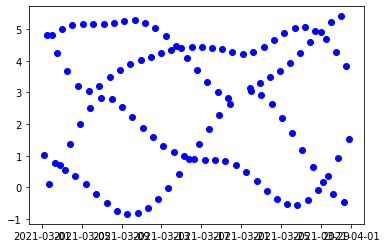

In [159]:
plt.scatter(X,y,color='blue')
plt.plot(X,lin2.predict(X),color='red')
plt.title('Linear Regression')
plt.xlabel('Date')
plt.ylabel('Height')
plt.show()

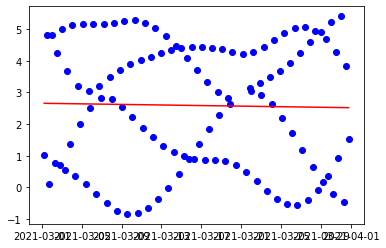

In [165]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
lin2 = LinearRegression()
lin2.fit(X_poly,y)
#a = lin2.predict()
plt.scatter(X,y,color='blue')
plt.plot(X, lin2.predict(X_poly),color='red')

